 This program can do cool stuff. It draws rectangles around moving objects

In [273]:
from scipy import ndimage
from scipy import misc
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
import imageio
import glob
import numpy as np
import pandas as pd
import time
import cv2

import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def threshold(x):
    if abs(x) > 80:
        return 1
    else:
        return 0
    
def drawRectangle(img, xmin, ymin, xmax, ymax):
    cv2.rectangle(currentImg, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2, 8)
    

def removeOutliers(X, neighbors=30, contamination=0.1):
    clf = LocalOutlierFactor(n_neighbors=neighbors, contamination=contamination)
    outlierSeries = pd.Series(clf.fit_predict(X))
    XFrame = pd.DataFrame(X)
    #remove all outliers (-1) from the Dataframe
    XFrame = XFrame[outlierSeries==1]
    return np.array(XFrame)

def getClusters(X, n=2):
    kmeans = KMeans(n_clusters=n)
    return kmeans.fit_predict(X)

def showImages(diff, threshold, X, Y):
    plt.figure()
    plt.imshow(diff, cmap="gray", )
    plt.title("The difference of the images")
    plt.figure()
    plt.imshow(np.absolute(diff), cmap="gray")
    plt.title("The difference of the images, but as absolute values")
    plt.figure()
    plt.imshow(threshold, cmap="gray")
    plt.title("Applying the threshold function to the difference of the images")
    
    height = len(diff)
    width = len(diff[0])
    print(height)
    print(width)
    plt.figure()
    plt.scatter(X[:, 1], X[:, 0], c=Y)
    plt.ylim(height, 0)
    plt.xlim(0, width)

show = 1

This cell reads all .jpg files from the the folder _input_ and will sort them. In order for the program to work properly, it is mandatory that the lexicographical order of the filenames matches the order, in which the images should be processed

In [271]:
#read the filepaths and sort them
filePaths = []
for filePath in glob.glob("input/*.jpg"):
    filePaths.append(filePath)
    
filePaths.sort()

#create np array for images. Determine dimensions by test reading the first imageq
testImage = imageio.imread(filePaths[0])
height = np.shape(testImage)[0]
width = np.shape(testImage)[1]

images = np.zeros((len(filePaths), height, width))


#convert the images to greyscale and write them into the np array
for i in range(len(filePaths)):
    image = imageio.imread(filePaths[i])
    grayImage = rgb2gray(image)
    images[i] = grayImage

First, two consecutive images will be subtracted from each other. A threshold function will then be applied to the result, so that only significant differences pass.
Afterwards outliers are sorted out. The remaining inliers are then passed to a clustering algorithm and bounding rectangles for the respective clusters are calculated. Those rectangle are then drawn onto the images which then are saved in the folder _out_

Problems: 
* Right now, the program can't figure out on its own how many clusters are needed to represent the different motions shown on the images. Therefor, a default of 2 clusters is used for every image.
* Parameters for the threshold function, LOF and clustering were tuned manually. Applying gridsearch could lead to better results


/home/luca/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Bounding rectangle for 0: X-Dimenstion: 1676-1732, Y-Dimenstion: 1015-1124
Bounding rectangle for 0: X-Dimenstion: 1087-1159, Y-Dimenstion: 1254-1365
0
Bounding rectangle for 1: X-Dimenstion: 1084-1154, Y-Dimenstion: 1264-1371
Bounding rectangle for 1: X-Dimenstion: 1701-1735, Y-Dimenstion: 1020-1107
1
Bounding rectangle for 2: X-Dimenstion: 1707-1741, Y-Dimenstion: 1043-1096
Bounding rectangle for 2: X-Dimenstion: 1071-1148, Y-Dimenstion: 1267-1380
2
Bounding rectangle for 3: X-Dimenstion: 1696-1743, Y-Dimenstion: 1039-1087
Bounding rectangle for 3: X-Dimenstion: 1683-1741, Y-Dimenstion: 1000-1063
1536
2048
3
Bounding rectangle for 4: X-Dimenstion: 1083-1153, Y-Dimenstion: 1191-1380
Bounding rectangle for 4: X-Dimenstion: 1717-1743, Y-Dimenstion: 1038-1067
4
Bounding rectangle for 5: X-Dimenstion: 1082-1159, Y-Dimenstion: 1240-1370
Bounding rectangle for 5: X-Dimenstion: 1704-1738, Y-Dimenstion: 1033-1073
5
Bounding rectangle for 6: X-Dimenstion: 1691-1729, Y-Dimenstion: 1010-1074
Bou

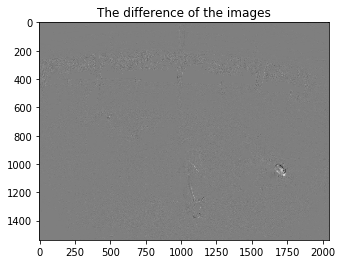

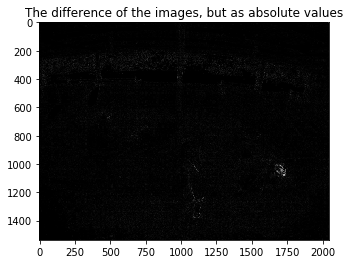

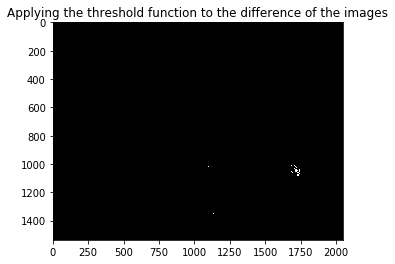

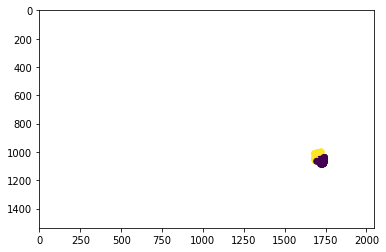

In [272]:
n_clusters = 2
for i in range(len(images) - 1):
    imageDiff = np.subtract(images[i], images[i+1])
    thresholdImage = [list(map(threshold, x)) for x in imageDiff]
   
    XFrame = pd.DataFrame(columns=['X', 'Y'])
    X = []
    for j in range(len(thresholdImage)):
        for k in range(len(thresholdImage[0])):
            if thresholdImage[j][k] == 1:
                X.append([j, k])
    
    X = removeOutliers(X=X, neighbors=200, contamination=0.2)
    Y = getClusters(X=X, n=n_clusters)
    
    labelledX = pd.DataFrame({'X': X[:, 1], 'Y': X[:, 0], 'label': Y})
    for clusterNum in range(n_clusters):
        cluster = labelledX.loc[labelledX['label'] == clusterNum]
        xmin = cluster['X'].min()
        xmax = cluster['X'].max()
        ymin = cluster['Y'].min()
        ymax = cluster['Y'].max()
        print("Bounding rectangle for " + str(i) + ": X-Dimenstion: " + str(xmin) + "-" + str(xmax) + 
          ", Y-Dimenstion: " + str(ymin) + "-" + str(ymax))

        cv2.rectangle(images[i], (xmin, ymin), (xmax, ymax), (255, 0, 0), 2, 8)
    
    cv2.imwrite("output/" + str(i) + ".png", images[i])
    
    if show == i:
        showImages(imageDiff, thresholdImage, X, Y)
    
    
    print(i)
    
    
    #imageDiffs[i] = np.subtract(images[i], images[i+1])
    #thresholdImages[i] = [list(map(threshold, x)) for x in imageDiffs[i]]